<a href="https://colab.research.google.com/github/sherna90/inteligencia_artificial/blob/master/redes_neuronales_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.2.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [35]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.reshape((-1,784))
x_test=x_test.reshape((-1,784))

Entrena un modelo generativo multinomial:

In [38]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB

mnb = MultinomialNB()
y_pred_naive_multinomial = mnb.fit(x_train, y_train).predict(x_test)

Entrena un modelo generativo gaussiano:

In [39]:
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
gnb = GaussianNB()
y_pred_naive_gaussian = gnb.fit(x_train_norm, y_train).predict(x_test_norm)

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization


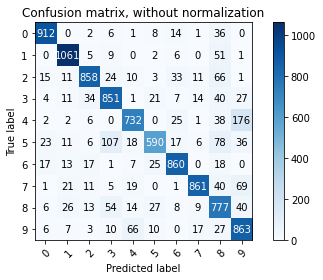

In [40]:
import numpy as np

plot_confusion_matrix(y_test,y_pred_naive_multinomial,classes=np.unique(y_train))

Confusion matrix, without normalization


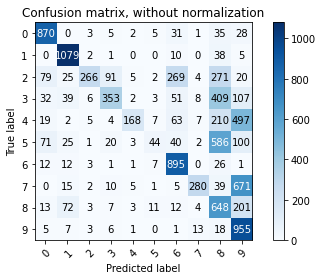

In [41]:
plot_confusion_matrix(y_test,y_pred_naive_gaussian,classes=np.unique(y_train))

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_naive_multinomial))


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       980
           1       0.91      0.93      0.92      1135
           2       0.90      0.83      0.86      1032
           3       0.80      0.84      0.82      1010
           4       0.84      0.75      0.79       982
           5       0.86      0.66      0.75       892
           6       0.89      0.90      0.89       958
           7       0.94      0.84      0.88      1028
           8       0.66      0.80      0.72       974
           9       0.71      0.86      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [43]:
print(classification_report(y_test, y_pred_naive_gaussian))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       980
           1       0.85      0.95      0.90      1135
           2       0.90      0.26      0.40      1032
           3       0.71      0.35      0.47      1010
           4       0.88      0.17      0.29       982
           5       0.55      0.05      0.09       892
           6       0.65      0.93      0.77       958
           7       0.88      0.27      0.42      1028
           8       0.28      0.67      0.40       974
           9       0.37      0.95      0.53      1009

    accuracy                           0.56     10000
   macro avg       0.69      0.55      0.51     10000
weighted avg       0.69      0.56      0.52     10000



# Redes Neuronales Tensorflow

In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop,SGD

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train=x_train.reshape((-1,784))
x_test=x_test.reshape((-1,784))
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [83]:
model = Sequential()
model.add(Dense(10, activation='softmax', input_shape=(784,)))
model.summary()

epochs=100
sgd = SGD(lr=0.01, decay=0, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=0,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [84]:
print(score)

[0.2650487720966339, 0.9265000224113464]


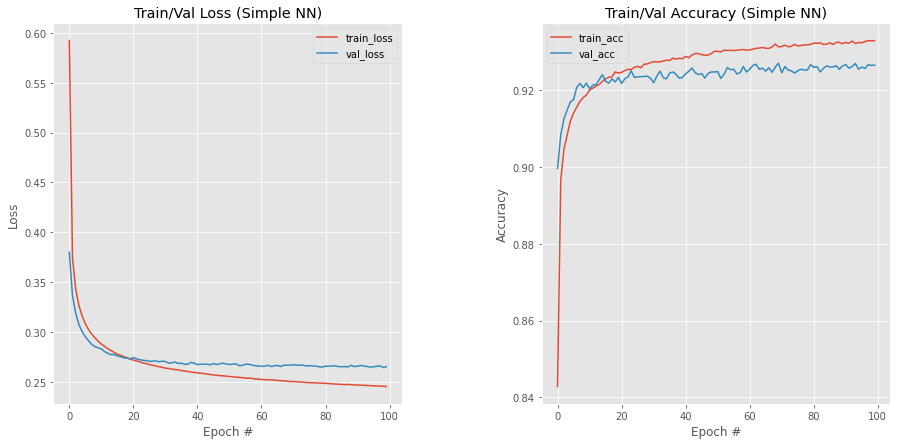

In [85]:
import matplotlib.pyplot as plt

N = np.arange(0, epochs)
plt.style.use("ggplot")

fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(1, 2, 1)
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Train/Val Loss (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Train/Val Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [75]:
y_pred_nn=model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.98      0.97      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.95      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.96      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



Confusion matrix, without normalization


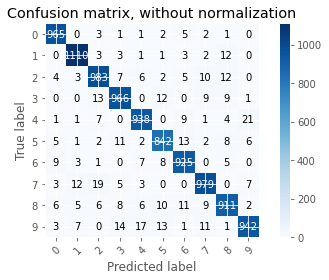

In [81]:
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1),classes=np.arange(num_classes))